SIN-393 - Introdução à Visão Computacional (2022-2)

# Aula 09 - Detecção e reconhecimento de objetos (Parte 2)

Prof. João Fernando Mari ([*joaofmari.github.io*](https://joaofmari.github.io/))

---

## Importando as bibliotecas
---

In [1]:
import time
import os
import glob as glob
from xml.etree import ElementTree as et
from packaging import version

import numpy as np
import cv2
from skimage import util
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import albumentations as A
from albumentations.pytorch import ToTensorV2

%matplotlib notebook

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.8.0
0.9.0


## Configurando acesso à GPU
---

In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Definindo configurações e hiperparâmetros
---

In [4]:
# Tamanho do lote (mini-batch)
BATCH_SIZE = 8 
# Tamanho das imagens de entrada
RESIZE_TO = 416 
# Número de épocas de treinamento
NUM_EPOCHS = 1 # 10 
# Número de núcleos do processador usados
NUM_WORKERS = 4

In [5]:
# training images and XML files directory
TRAIN_DIR = '/home/joao/DATASETS/Uno Cards v2/train'

# validation images and XML files directory
VALID_DIR = '/home/joao/DATASETS/Uno Cards v2/valid'

# classes: 0 index is reserved for background
CLASSES = ['__background__', '11', '9', '13', '10', '6', '7', '0', '5', '4', '2', '14', '8', '12', '1', '3']
NUM_CLASSES = len(CLASSES)

# location to save model and plots
OUT_DIR = 'outputs'

## Custom dataset

In [6]:
# the dataset class
class CustomDataset(Dataset):
    
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)
        
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        
        # read the image
        image = cv2.imread(image_path)
        
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            yamx_final = (ymax/image_height)*self.height
            
            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        
        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target
    
    def __len__(self):
        return len(self.all_images)

## Creating datasets
---

In [7]:
# define the training tranforms
train_transform = A.Compose([A.Flip(0.5),
                             A.RandomRotate90(0.5),
                             A.MotionBlur(p=0.2),
                             A.MedianBlur(blur_limit=3, p=0.1),
                             A.Blur(blur_limit=3, p=0.1),
                             ToTensorV2(p=1.0),], 
                            bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# define the validation transforms
valid_transform = A.Compose([ToTensorV2(p=1.0),],
                            bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [8]:
train_dataset = CustomDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, train_transform)
valid_dataset = CustomDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, valid_transform)

print(len(train_dataset))
print(len(valid_dataset))

6295
1798


## Creating dataloaders
---

In [9]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              collate_fn=collate_fn
                             )

valid_dataloader = DataLoader(valid_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS,
                              collate_fn=collate_fn
                             )

## Visualizing sample images
---

In [10]:
# function to visualize a single sample
def visualize_sample(image, target):
    for box_num in range(len(target['boxes'])):
        box = target['boxes'][box_num]
        label = CLASSES[target['labels'][box_num]]
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
        cv2.putText(image, label, (int(box[0]), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
    ### plt.imshow(image[:,:,::-1])
    return image[:,:,::-1]/ 255.

Number of training images: 6295


<IPython.core.display.Javascript object>


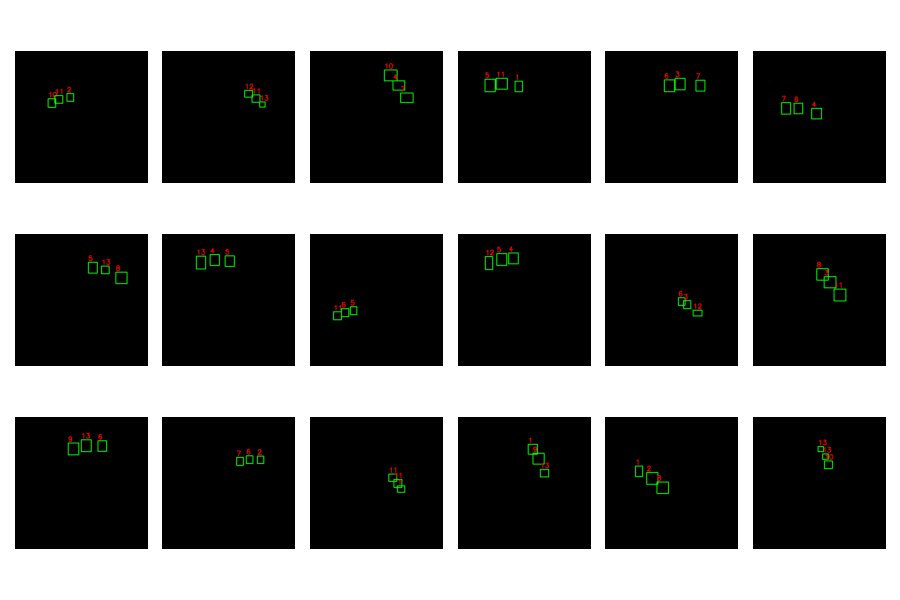

In [11]:
# sanity check of the Dataset pipeline with sample visualization
dataset = CustomDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES)
print(f"Number of training images: {len(dataset)}")

   
fig, ax  = plt.subplots(3, 6, figsize=(9, 6))

# for i, (image, target) in enumerate(dataset[:19]):
for i in range(18):
    image, target = dataset[i]
    image = visualize_sample(image, target)
    ### print(image.min(), image.max())
    
    ax[i//6, i%6].imshow(image)
    ### ax[i//6, i%6].set_title(str(filename))
    ax[i//6, i%6].axis('off')
    
fig.tight_layout()
plt.show()

## Creating the model
---

In [12]:
# load Faster RCNN pre-trained model
if version.parse(torchvision.__version__) < version.parse('0.13'):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
else:
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')

# get the number of input features 
in_features = model.roi_heads.box_predictor.cls_score.in_features

# define a new head for the detector with required number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES) 

# Envia o modelo para a GPU.
model = model.to(DEVICE)

In [13]:
# Parâmetros do modelo
params = [p for p in model.parameters() if p.requires_grad]

# Otimizador - SGD
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

## Treinando o modelo
---

In [14]:
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    
    # start timer and carry out training and validation
    start = time.time()
    
    # TRAINING
    # ====================
    train_loss_hist = 0.0
    train_iterations = 0
    
    for i, (images, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Send the data to GPU
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        # >>>> FORWARD
        loss_dict = model(images, targets)
        
        # Perda do lote
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_list.append(loss_value)

        ### train_loss_hist.send(loss_value)
        train_loss_hist += loss_value
        train_iterations += 1

        # <<<< BACKWARD
        losses.backward()
        optimizer.step()
        ### train_itr += 1

        # update the loss value beside the progress bar for each iteration
        if i % 200 == 0:
            print(f'Iteration {i}. Training loss: {loss_value:.4f}')
        
    # Consolida a perda da época
    if train_iterations == 0:
        train_loss_hist = 0
    else:
        train_loss_hist = 1.0 * train_loss_hist / train_iterations
        
    # Armazena a perda da época
    ### test_loss_list.append(test_loss_hist)
        
    # VALIDATION
    # ====================
    val_loss_hist = 0.0
    val_iterations = 0
    
    for i, (images, targets) in enumerate(valid_dataloader):

        # Send the data to GPU
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        # >>>> FORWARD
        with torch.no_grad():
            loss_dict = model(images, targets)
            
        # Perda do lote
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        # Armazena a perda deste lote (iteração)
        val_loss_list.append(loss_value)
        
        # Atualiza a perda da época
        val_loss_hist += loss_value
        val_iterations += 1
        
        # Imprime a perda desta iteração.
        if i % 200 == 0:
            print(f'Iteration {i} \t Validation loss: {loss_value:.4f}')
        
    # Consolida a perda da época
    if val_iterations == 0:
        val_loss_hist = 0
    else:
        val_loss_hist = 1.0 * val_loss_hist / val_iterations
        
    # Armazena a perda da época
    ### val_loss_list.append(val_loss_hist)
    
    # Contabiliza o tempo da época
    end = time.time() - start
    
    # PRINTING...
    print(f'Epoch {epoch}/{NUM_EPOCHS} - TRAIN Loss: {train_loss_hist:.4f} - VAL. Loss: {val_loss_hist:.4f} ({end:.4f} seconds)')


EPOCH 1 of 1
Iteration 0. Training loss: 3.4238
Iteration 200. Training loss: 0.7380
Iteration 400. Training loss: 0.4297
Iteration 600. Training loss: 0.3423
Iteration 0 	 Validation loss: 0.2994
Iteration 200 	 Validation loss: 0.2632
Epoch 0/1 - TRAIN Loss: 0.5417 - VAL. Loss: 0.2944 (738.2484 seconds)


## Plotando as curvas de treinamento
---

<IPython.core.display.Javascript object>


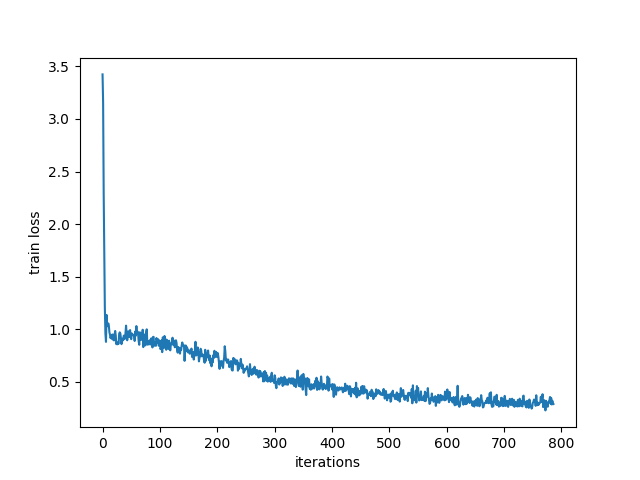

<IPython.core.display.Javascript object>


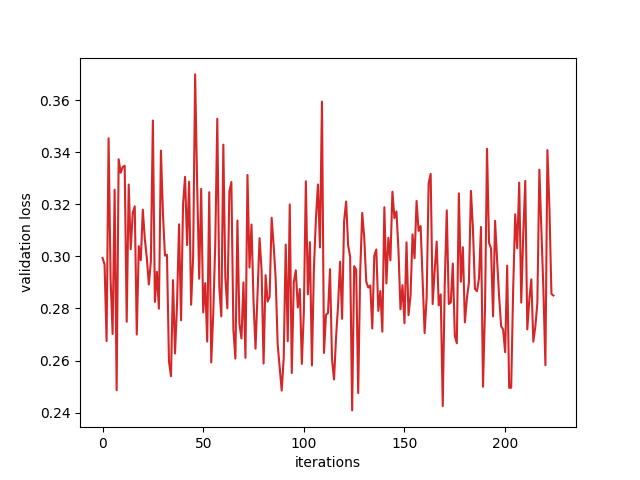

Text(0, 0.5, 'validation loss')

In [15]:
figure_1, train_ax = plt.subplots()
train_ax.plot(train_loss_list, color='tab:blue')
train_ax.set_xlabel('iterations')
train_ax.set_ylabel('train loss')

figure_2, valid_ax = plt.subplots()
valid_ax.plot(val_loss_list, color='tab:red')
valid_ax.set_xlabel('iterations')
valid_ax.set_ylabel('validation loss')

## Testando o modelo
---

In [16]:
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

model.eval()

# directory where all the images are present
DIR_TEST = '/home/joao/DATASETS/Uno Cards v2/test'

test_images = glob.glob(f"{DIR_TEST}/*.jpg")
print(f"Test instances: {len(test_images)}")

# define the detection threshold...
# Any detection having score below this will be discarded
detection_threshold = 0.8

if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

Test instances: 899


In [17]:
for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    
    # Carrega a imagem (BGR)
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    
    # >>> FORWARD
    with torch.no_grad():
        outputs = model(image.to(DEVICE))
    
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
        
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            color = COLORS[CLASSES.index(class_name)]
            cv2.rectangle(orig_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
            cv2.putText(orig_image, class_name, 
                        (int(box[0]), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, lineType=cv2.LINE_AA)
            
        # Grava as imagens
        ### cv2.imwrite(f"inference_outputs/images/{image_name}.jpg", orig_image)
        cv2.imwrite(f'{OUT_DIR}/{image_name}.png', orig_image)
        
    
print('Done!')
cv2.destroyAllWindows()

Done!


<IPython.core.display.Javascript object>


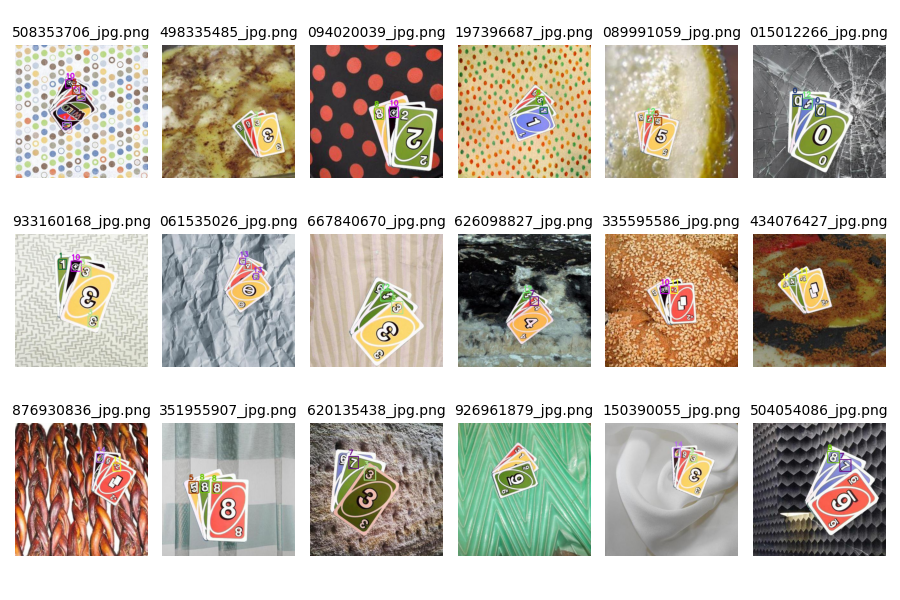

In [18]:
img_out_list = os.listdir(OUT_DIR)


fig, ax  = plt.subplots(3, 6, figsize=(9, 6))

for i in range(18):
    filename = img_out_list[i]
    image = cv2.imread(os.path.join(OUT_DIR, filename))
    
    ax[i//6, i%6].imshow(image[:,:,::-1], cmap='gray')
    ax[i//6, i%6].set_title(str(filename), fontsize=10)
    ax[i//6, i%6].axis('off')
    
fig.tight_layout()
plt.show()

## Bibliography
---

* Sovit Ranjan Rath. **A Simple Pipeline to Train PyTorch Faster RCNN Object Detection Model.**
    * https://debuggercafe.com/a-simple-pipeline-to-train-pytorch-faster-rcnn-object-detection-model/
* Uno Cards Dataset.
    * https://public.roboflow.com/object-detection/uno-cards